In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import json

import os
os.chdir('/home/raid/Desktop/Shubh/DLProject/experiments')

from helpers.trainer import Trainer
from helpers.train_all import TrainerAll
from helpers.train_all_2 import TrainerAll2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def whitening_transform(data):
    # Center the data (subtract mean)
    mean = torch.mean(data, dim=0, keepdim=True)
    centered_data = data - mean

    # Compute covariance matrix
    covariance_matrix = torch.matmul(centered_data.T, centered_data) / (centered_data.size(0) - 1)

    # Compute eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = torch.eig(covariance_matrix, eigenvectors=True)

    # Whitening transformation
    whitened_data = torch.matmul(torch.matmul(eigenvectors, torch.diag(1 / torch.sqrt(eigenvalues[:, 0]))), eigenvectors.T) @ centered_data.T
    
    return whitened_data.T

In [4]:
# Defining batch size as given on page 7 on Adam Research Paper
batch_size = 128    

# Calculate the number of workers to use for DataLoader
num_workers = 8

# transformations
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
os.chdir('/home/raid/Desktop/Shubh/DLProject/experiments/models')

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='../../datasets/', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='../../datasets/', train=False, download=True, transform=transform)

# trainset = whitening_transform(trainset)
# testset = whitening_transform(testset)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)  # 3 input channels, 64 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2) # 64 input channels, 64 output channels, 5x5 kernel
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2) # 64 input channels, 128 output channels, 5x5 kernel

        self.fc1 = nn.Linear(128 * 3 * 3, 1000)  # 128 * 4 * 4 input features, 1000 output features
        self.fc2 = nn.Linear(1000, 10)  # 1000 input features, 10 output classes
        
    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        
        # Flatten the feature maps
        x = x.view(-1, 128 * 3 * 3)

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))

        
        # Output layer with softmax activation
        x = self.fc2(x)
        # x = F.log_softmax(x, dim=1)

        return x


In [7]:
criterion = nn.CrossEntropyLoss()
epochs = 100

optimizer = optim.Adam

In [8]:
model = CNN().to(device)
trainer = TrainerAll(train_loader, test_loader, criterion, epochs=50)

head1, head2, head3 = 'EPOCHS', 'TRAIN LOSS', 'VAL LOSS'
print(f'{head1 :>6} {head2 :>25} {head3 :>25}')

log = trainer.train_all_optim(model)

EPOCHS                TRAIN LOSS                  VAL LOSS
Optimizer : Adam_custom


/home/raid/miniconda3/envs/dl/lib/python3.12/site-packages/torch/autograd/__init__.py:266: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1177.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    10         2.111333718385233        2.1030188180223295
    20        2.0496849407015554         2.039803335938273
    30         2.137153865126393         2.141897720626638
    40        2.2184373015333017         2.214339654656905
    50        2.2217623138671643        2.2163842901398865
Optimizer : Adam_torch
    10       0.27884716664433784        0.9235653386840338
    20       0.09245149064761446        1.5734048236774494
    30       0.06343613245793621         1.938446123388749
    40       0.07203037710354218        2.4503619203084632
    50        0.0729206725895462        2.5865504153167147
Optimizer : RMS_torch
    10       0.34283549397650276        1.0941413995585865
    20       0.08811955260293906        1.7713328328313707
    30        0.0734700294017382         2.325442967535574
    40        0.0667650152253561        2.6659345853177805
    50       0.06692086375677837        3.3281881688516353
Optimizer : AdaGrad_torch
    10         1.111689001550455          1.

In [ ]:
trainer_original = TrainerAll(train_loader, test_loader, criterion, epochs=50)

head1, head2, head3 = 'EPOCHS', 'TRAIN LOSS', 'VAL LOSS'
print(f'{head1 :>6} {head2 :>25} {head3 :>25}')

log_original = trainer_original.train_all_optim(model)

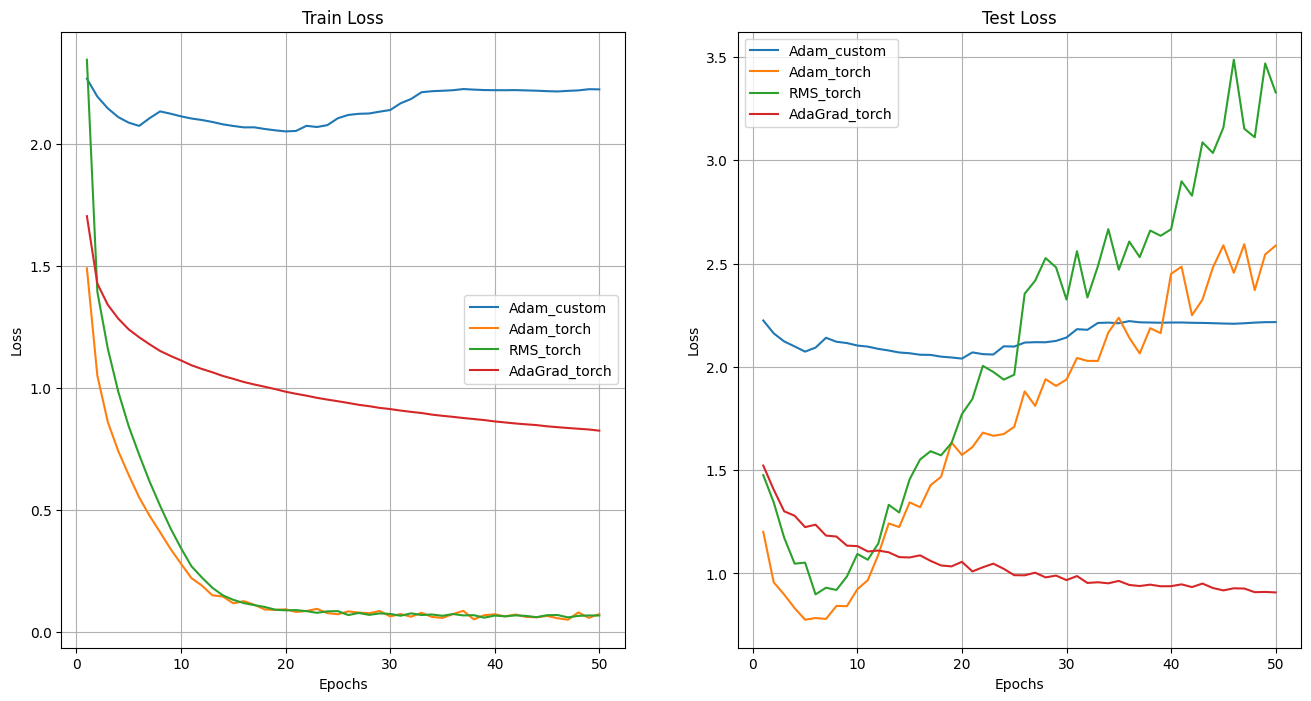

In [9]:
trainer.plot_loss_graphs()
# trainer_original.plot_loss_graphs()

In [10]:
import json

with open('../results/logs/CIFAR_CNN.json', 'w', encoding ='utf8') as file: 
    json.dump(log, file, ensure_ascii = False, indent=4) 

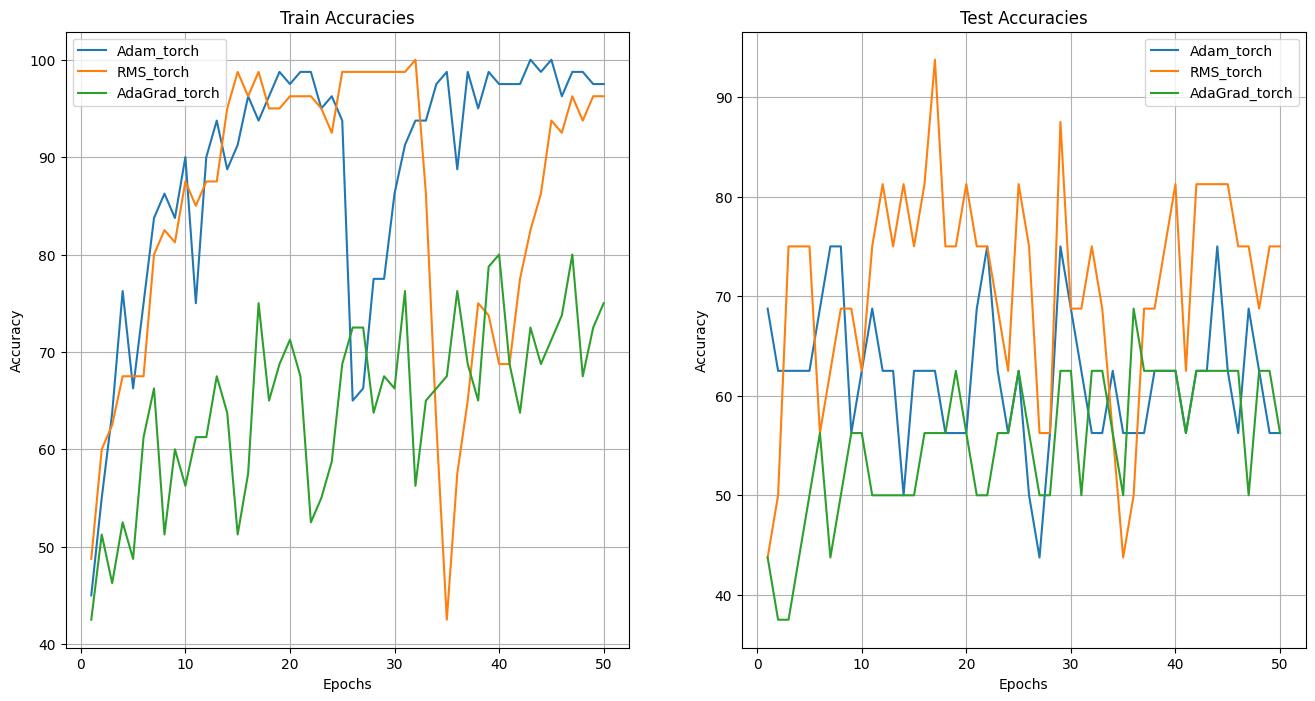

In [11]:
trainer.plot_acc_graphs()
trainer_original.plot_acc_graphs()